<a href="https://colab.research.google.com/github/alexlinapp/python_tools_practice/blob/main/resNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchinfo

In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from fastai.vision.all import *
import torch.nn.functional as F
from torchinfo import summary
print(torch.__version__)

2.6.0+cu124


In [4]:
path = untar_data(URLs.IMAGENETTE)

In [5]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

In [7]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [6]:
def get_dls(bs, size, shuffle=True):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs, shuffle=shuffle)
def get_data(url, presize, resize, bs=64):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=bs)

In [7]:
dls = get_dls(64, 224, shuffle=True)
len(dls.one_batch()), dls.one_batch()[0].shape
#show_image(dls.one_batch()[0][0])
xb, yb = dls.one_batch()

(<Axes: >,
 <Axes: >,
 TensorCategory([0, 6, 9, 5, 1, 1, 0, 9, 4, 9, 7, 6, 4, 8, 7, 4, 1, 5, 0, 2, 4,
                 1, 1, 6, 4, 5, 0, 8, 2, 9, 9, 8, 4, 9, 5, 3, 6, 3, 4, 3, 6, 7,
                 4, 7, 5, 7, 8, 8, 4, 4, 4, 2, 1, 9, 0, 2, 7, 3, 0, 9, 8, 6, 0,
                 3]))

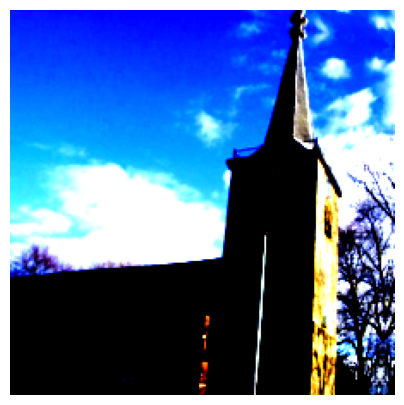

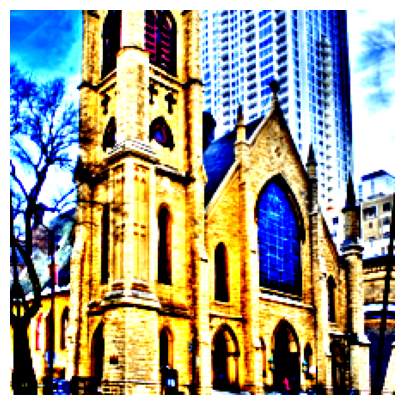

In [11]:
xb.mean(dim=[0,2,3]), xb.std(dim=[0,2,3]), yb
show_image(xb[8]), show_image(xb[12]), yb

In [8]:
dls = get_data(URLs.IMAGENETTE_320, 160, 224)
xb, yb = dls.one_batch()
xb.shape, yb.shape, type(dls), type(dls.train)

(torch.Size([64, 3, 224, 224]),
 torch.Size([64]),
 fastai.data.core.DataLoaders,
 fastai.data.core.TfmdDL)

In [19]:
def conv_layer(in_channels, out_channels, act_cls = nn.ReLU(), ks=3, stride=2, padding=0):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=ks, stride=stride, padding=padding),
      nn.BatchNorm2d(out_channels)]
  if act_cls is not None: layers.append(act_cls)
  return nn.Sequential(*layers)

def bottleneck_block1(in_channels, out_channels, ks=3, act_cls = nn.ReLU(), stride=1):
  return nn.Sequential(conv_layer(in_channels, out_channels=out_channels//4, act_cls=act_cls, ks=1, stride=1),
                       conv_layer(in_channels=out_channels//4, out_channels=out_channels//4, act_cls=act_cls, ks=ks, stride=stride, padding=ks//2),
                       conv_layer(in_channels=out_channels//4, out_channels=out_channels, act_cls=None, ks=1, stride=1))

class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, ks=3, stride=2):
    super().__init__()
    self.conv_block1 = nn.Sequential(conv_layer(in_channels, out_channels, ks=ks, stride=stride, padding=ks//2),
                                     conv_layer(out_channels, out_channels, act_cls = None, ks=ks, stride=1, padding=ks//2))
    self.id_conv = nn.Identity() if in_channels==out_channels and stride == 1 else conv_layer(in_channels, out_channels, act_cls = None, ks=1, stride=stride)
  def forward(self, x):
    x = self.conv_block1(x) + self.id_conv(x)
    return F.relu(x)

def ResBlock2(in_channels, out_channels, ks=3, stride=2):
  return nn.Sequential(ResBlock(in_channels, out_channels, ks=ks, stride=stride),
                       ResBlock(out_channels, out_channels, ks=ks, stride=1))

class ResBlock3(nn.Module):
  def __init__(self, in_channels, out_channels, ks=3, stride=2):
    super().__init__()
    self.conv_block1 = bottleneck_block1(in_channels, out_channels, ks=ks, act_cls = nn.ReLU(), stride=stride)
    self.id_conv = nn.Identity() if in_channels==out_channels and stride==1 else conv_layer(in_channels, out_channels, act_cls = None, ks=1, stride=stride)
  def forward(self, x):
    return F.relu(self.conv_block1(x) + self.id_conv(x))

class ResNet(nn.Module):
  def __init__(self, in_channels=3, num_classes=10):
    super().__init__()
    self.block1 = nn.Sequential(conv_layer(in_channels, 16),
                                conv_layer(16, 32),
                                conv_layer(32, 64),
                                conv_layer(64, 128),
                                conv_layer(128, 256))

    # self.layer1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=(3, 3), stride=2)
    # self.relu = nn.ReLU()
    # self.layer2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=2)
    # self.layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2)
    # self.layer4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=2)
    # self.layer5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=2)
    #self.layer6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=2)
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.lastlayer = nn.Linear(256, num_classes)

  def forward(self, x):
    # x = self.layer1(x)
    # x = self.relu(x)
    # x = self.layer2(x)
    # x = self.relu(x)
    # x = self.layer3(x)
    # x = self.relu(x)
    # x = self.layer4(x)
    # x = self.relu(x)
    # x = self.layer5(x)
    # x = self.relu(x)
    x = self.block1(x)
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    return self.lastlayer(x)

class ResNet2(nn.Module):
  def __init__(self, in_channels=3, num_classes=10):
    super().__init__()
    self.block1 = ResBlock(in_channels, 16)
    self.block2 = ResBlock(16, 32)
    self.block3 = ResBlock(32, 64)
    self.block4 = ResBlock(64, 128, stride=1)
    self.block5 = ResBlock(128, 256, stride=1)
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.lastlayer = nn.Linear(256, num_classes)
  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    return self.lastlayer(x)

class ResNet3(nn.Module):
  def __init__(self, in_channels=3, num_classes=10):
    super().__init__()
    self.block1 = ResBlock2(in_channels, 16)
    self.block2 = ResBlock2(16, 32)
    self.block3 = ResBlock2(32, 64)
    self.block4 = ResBlock2(64, 128)
    self.block5 = ResBlock2(128, 256)
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.lastlayer = nn.Linear(256, num_classes)
  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    return self.lastlayer(x)

class ResNet4(nn.Module):
  def __init__(self, in_channels=3, num_classes=10):
    super().__init__()
    self.block1 = ResBlock2(in_channels, 16, stride=2)
    self.block2 = ResBlock2(16, 32, stride=1)
    self.block3 = ResBlock2(32, 64, stride=2)
    self.block4 = ResBlock2(64, 128, stride=2)
    self.block5 = ResBlock3(128, 256, stride=2)
    self.block6 = ResBlock3(256, 512, stride=2)
    self.pool = nn.AdaptiveAvgPool2d(1)
    self.lastlayer = nn.Linear(512, num_classes)
  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    #print(x.shape)
    x = self.block4(x)
    #print(x.shape)
    x = self.block5(x)
    #print(x.shape)
    x = self.block6(x)
    #print(x.shape)
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    return self.lastlayer(x)



In [17]:
model1 = ResNet(3, 10)
#ummary(model1, input_size=(64, 3, 128, 128))
model2 = ResNet2(3, 10)
#summary(model2, input_size=(64, 3, 128, 128))
model3 = ResNet3(3, 10)
summary(model3, input_size=(64, 3, 128, 128))
model4 = ResNet4(3, 10)
summary(model4, input_size=(64, 3, 128, 128))
# xb, __ = dls.one_batch()
# model4(xb)
# rb3v1 = ResBlock3(3, 16)
# rb3v1(xb)
# class ResBlock3(nn.Module):
#   def __init__(self, in_channels, out_channels, ks=3, stride=2):
#     super().__init__()
#     self.conv_block1 = bottleneck_block1(in_channels, out_channels, ks=ks, act_cls = nn.ReLU())
#     self.id_conv = nn.Identity() if in_channels==out_channels else conv_layer(in_channels, out_channels, act_cls = None, ks=1, stride=stride)
#   def forward(self, x):
#     x = self.conv_block1(x) + self.id_conv(x)
#     return F.relu(x)

Layer (type:depth-idx)                        Output Shape              Param #
ResNet4                                       [64, 10]                  --
├─Sequential: 1-1                             [64, 16, 64, 64]          4,704
│    └─ResBlock: 2-1                          [64, 16, 64, 64]          96
│    │    └─Sequential: 3-1                   [64, 16, 64, 64]          2,832
├─Sequential: 1-14                            --                        (recursive)
│    └─ResBlock: 2-20                         --                        (recursive)
│    │    └─Sequential: 3-26                  --                        (recursive)
├─Sequential: 1-5                             --                        (recursive)
│    └─ResBlock: 2-3                          --                        (recursive)
│    │    └─Sequential: 3-3                   --                        (recursive)
│    │    └─Sequential: 3-4                   [64, 16, 64, 64]          96
│    └─ResBlock: 2-4               

In [13]:
def train_model(model, optimizer, loss_fn, train_loader, epochs=3, device="cpu"):
  model.to(device)
  model.train()
  for epoch in range(epochs):
    train_loss = 0
    train_accruracy = 0
    train_correct = 0
    i = 0
    for xb, yb in train_loader:
      xb = Tensor(xb).to(device)
      yb = Tensor(yb).to(device)
      optimizer.zero_grad()
      pred = model(xb)          # (batch_size, num_classes)
      loss = loss_fn(pred, yb)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * xb.size(0)
      train_accruracy += (pred.argmax(dim=1) == yb).float().mean().item()
      train_correct += (pred.argmax(dim=1) == yb).sum().item()
      i += 1
      if (i >= 3): break
    avg_loss = train_loss / (i * train_loader.bs)
    avg_acc = train_correct / (i * train_loader.bs)
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {avg_loss}, Accuracy: {avg_acc}")

In [14]:
# xb, yb = dls.one_batch()
# yb = Tensor(yb)
# type(Tensor(xb)), type(yb), xb
model1 = ResNet(3, 10) #original lr = 3e-4
train_model(model1, torch.optim.Adam(model1.parameters(), lr=0.001), nn.CrossEntropyLoss(), dls.train, 5, "cpu")

Epoch: 1/5, Loss: 2.1968677838643393, Accuracy: 0.203125
Epoch: 2/5, Loss: 2.105215867360433, Accuracy: 0.296875
Epoch: 3/5, Loss: 1.945490042368571, Accuracy: 0.3072916666666667
Epoch: 4/5, Loss: 2.0214370489120483, Accuracy: 0.2916666666666667
Epoch: 5/5, Loss: 1.9250205755233765, Accuracy: 0.2916666666666667


In [20]:
model2 = ResNet2(3, 10)
train_model(model2, torch.optim.Adam(model2.parameters(), lr=0.001), nn.CrossEntropyLoss(), dls.train, 5, "cpu")

Epoch: 1/5, Loss: 2.3196136951446533, Accuracy: 0.16145833333333334
Epoch: 2/5, Loss: 2.174582560857137, Accuracy: 0.2604166666666667
Epoch: 3/5, Loss: 2.0067184368769326, Accuracy: 0.265625
Epoch: 4/5, Loss: 2.0082352558771768, Accuracy: 0.296875
Epoch: 5/5, Loss: 1.9413584073384602, Accuracy: 0.28125


In [18]:
model3 = ResNet3(3, 10)
train_model(model3, torch.optim.Adam(model3.parameters(), lr=0.001), nn.CrossEntropyLoss(), dls.train, 5, "cpu")

Epoch: 1/5, Loss: 2.4383703072865806, Accuracy: 0.19791666666666666
Epoch: 2/5, Loss: 2.3616341749827066, Accuracy: 0.16145833333333334
Epoch: 3/5, Loss: 2.1503987312316895, Accuracy: 0.2604166666666667
Epoch: 4/5, Loss: 2.150382955869039, Accuracy: 0.2604166666666667
Epoch: 5/5, Loss: 1.9933091402053833, Accuracy: 0.3020833333333333


In [15]:
model4 = ResNet4(3, 10)
train_model(model4, torch.optim.Adam(model4.parameters(), lr=0.001), nn.CrossEntropyLoss(), dls.train, 5, "cpu")

Epoch: 1/5, Loss: 2.2885396480560303, Accuracy: 0.20833333333333334
Epoch: 2/5, Loss: 2.2535203297932944, Accuracy: 0.15625


KeyboardInterrupt: 